In [219]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

import os, fnmatch
from scipy.special import gamma

from cross_sections import sigma
from classical_formula import sigma_T_classical, sigma_V_classical

fontsize=14
legendfontsize=12
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
rc('font', family='serif', serif='Computer Modern Roman')

In [189]:
def get_numerical_data(label_str,path_str,no_bad_data=False):
    
    path = 'F:\\Dropbox\\Research\\Classical SIDM\\phase shift data\\' + path_str + '\\'
    output = []
    
    for file_name in os.listdir(path):

        temp = file_name.replace('.csv', '_')
        if fnmatch.fnmatch(temp, '*_' + label_str + '_*'):
            
            df = pd.read_csv(path + file_name)

            beta = float(temp.split('_')[5])
            kappa = float(temp.split('_')[3])
            sigmaT, sigmaV = 4*np.pi/kappa**2 * np.array(sigma_numerical(df,no_bad_data=no_bad_data))
            
            output.append( [beta, kappa, sigmaT, sigmaV] )
            
    output = np.array(output)
            
    return output

def sigma_Hulthen(beta,kappa,eps=1.6):
    
    i = 1j
    unity = 1+0j
    
    lam_p = 1 + i*kappa/eps * (1 + np.sqrt( 1 + 2*beta*eps*unity ) )
    lam_m = 1 + i*kappa/eps * (1 - np.sqrt( 1 + 2*beta*eps*unity ) )
    
    arg = i*gamma(lam_p+lam_m-2)/gamma(lam_p)/gamma(lam_m)
    delta_0 = np.angle(arg)
    
    sigma_s_wave = 4*np.pi/kappa**2 * np.sin(delta_0)**2
#     print(np.sin(delta_0), beta, arg)
    
    
    return sigma_s_wave

def sigma_numerical(df,no_bad_data=False):
    
    L = np.array(df['L'])
    delta_L = np.array(df['delta_L'])
    
    if no_bad_data:
        
        sel = np.where( df['Converged'] == True)
        L = L[sel]
        delta_L = delta_L[sel]
        
#     print(L)
#     print(delta_L)
#     print((L[:-1]+1)*np.sin( delta_L[1:] - delta_L[:-1] )**2 )
    
    sigma_T = np.sum( (L[:-1]+1)*np.sin( delta_L[1:] - delta_L[:-1] )**2 )
    sigma_V = np.sum( (L[:-2]+1)*(L[:-2]+2)/(2*L[:-2]+3)*np.sin( delta_L[2:] - delta_L[:-2] )**2 )
    
    return sigma_T, sigma_V

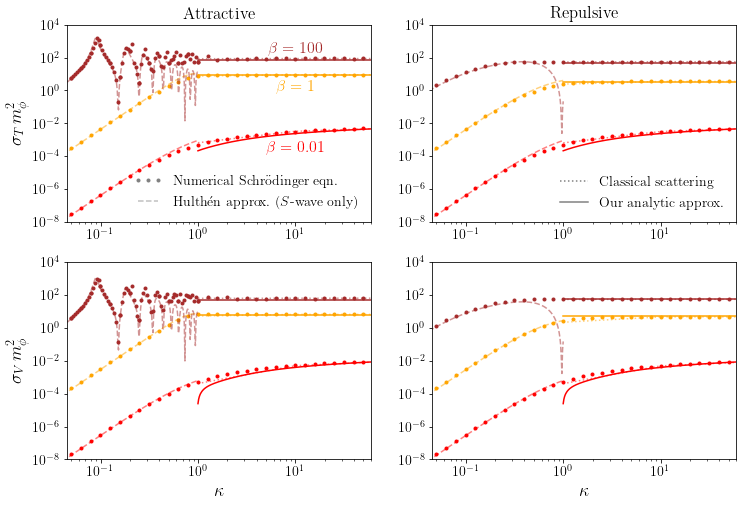

In [250]:
# plot vs kappa

fig, axs = plt.subplots(2, 2, figsize=(12,12/1.5))

beta_strings = ['beta_0.01', 'beta_1.', 'beta_100.']
color_list = ['red', 'orange', 'brown']

lx = [1,10]
ly = [1e-20,1e-20]
axs[0,0].plot(lx,ly,'.',color='gray')
axs[0,0].plot(lx,ly,color='gray',linestyle='dashed',alpha=0.5)
axs[0,0].legend([r'Numerical Schr\"odinger eqn.', r'Hulth\'{e}n approx.~($S$-wave only)'],frameon=False,numpoints=3)

axs[0,1].plot(lx,ly,color='gray',linestyle='dotted')
axs[0,1].plot(lx,ly,color='gray')
axs[0,1].legend(['Classical scattering', 'Our analytic approx.'],frameon=False)


for bs,c in zip(beta_strings, color_list):

    # Numerical plot: attractive
    num_data = get_numerical_data(bs, 'attractive_kappa')
    kappa = num_data[:,1]
    beta = num_data[0,0]
    sig_T = num_data[:,2]
    sig_V = num_data[:,3]
    axs[0,0].plot(kappa,sig_T,'.',color=c)
    axs[1,0].plot(kappa,sig_V,'.',color=c)

    # Hulthen: attractive
    kappa = np.logspace(-2,0,num=300)
    sigma_Hul = np.array([sigma_Hulthen(-beta,k,eps=1.6) for k in kappa])
    # transfer
    axs[0,0].plot(kappa, sigma_Hul, '--', color=c, alpha=0.5)
    # viscosity
    axs[1,0].plot(kappa, 2/3*sigma_Hul, '--', color=c, alpha=0.5)
    
    # Numerical plot: repulsive
    num_data = get_numerical_data(bs, 'repulsive_kappa')
    kappa = num_data[:,1]
    beta = num_data[0,0]
    sig_T = num_data[:,2]
    sig_V = num_data[:,3]
    axs[0,1].plot(kappa,sig_T,'.',color=c)
    axs[1,1].plot(kappa,sig_V,'.',color=c)

    # Hulthen: repulsive
    kappa = np.logspace(-2,0,num=300)
    sigma_Hul = np.array([sigma_Hulthen(beta,k,eps=1.6) for k in kappa])
    # transfer
    axs[0,1].plot(kappa, sigma_Hul, linestyle='dashed', color=c, alpha=0.5)
    # viscosity
    axs[1,1].plot(kappa, 2/3*sigma_Hul, linestyle='dashed', color=c, alpha=0.5)

num_data = get_numerical_data('beta_100.', 'attractive_kappa_fine')
kappa = num_data[:,1]
beta = num_data[0,0]
sig_T = num_data[:,2]
sig_V = num_data[:,3]
axs[0,0].plot(kappa,sig_T,'.',color='brown')
axs[1,0].plot(kappa,sig_V,'.',color='brown')

# df = pd.read_csv('F:\\Dropbox\\Research\\SIDM particle models\\crosssec_attractive.csv', names=['a','b','cs','Lmax'])
# df['beta'] = 1/(2*df['a']**2*df['b'])
# df['kappa'] = df['a']*df['b']
# df['sigma_T_reduced'] = df['cs']*4*np.pi/(df['a']**2*df['b']**2)
# sel = df.loc[ (df['beta'] > 99) & (df['beta'] < 101) & (df['kappa'] < 1) & (df['kappa'] > 0.08) ]
# plt.plot(sel['kappa'], sel['sigma_T_reduced'], '.', markersize=3)

# classical formulas

beta_list = [0.01,1,100]
for beta, c in zip(beta_list, color_list):
    
    kappa = np.logspace(0,2,num=300)
    
    sig = [ np.pi*sigma(k, beta, mode = 'T', sign = 'attractive') for k in kappa ]
    axs[0,0].plot(kappa, sig, color=c)
    
    sig = [ np.pi*sigma(k, beta, mode = 'T', sign = 'repulsive') for k in kappa ]
    axs[0,1].plot(kappa, sig, color=c)
    
    sig = [ np.pi*sigma(k, beta, mode = 'V', sign = 'attractive') for k in kappa ]
    axs[1,0].plot(kappa, sig, color=c)
    
    sig = [ np.pi*sigma(k, beta, mode = 'V', sign = 'repulsive') for k in kappa ]
    axs[1,1].plot(kappa, sig, color=c)

for beta, c in zip(beta_list, color_list):
    
    kappa = np.logspace(0,2,num=3)
    
    sig = [ sigma_T_classical(-beta, kappa=k) for k in kappa ]
#     sig = [ sigma_T_classical(-beta) ] * len(kappa)
    axs[0,0].plot(kappa, sig, linestyle='dotted', color=c, alpha=0.5)

    sig = [ sigma_T_classical(beta, kappa=k) for k in kappa ]
#     sig = [ sigma_T_classical(beta) ] * len(kappa)
    axs[0,1].plot(kappa, sig, linestyle='dotted', color=c, alpha=0.5)

    sig = [ sigma_V_classical(-beta, kappa=k) for k in kappa ]
#     sig = [ sigma_V_classical(-beta) ] * len(kappa)
    axs[1,0].plot(kappa, sig, linestyle='dotted', color=c, alpha=0.5)

    sig = [ sigma_V_classical(beta, kappa=k) for k in kappa ]
#     sig = [ sigma_V_classical(beta) ] * len(kappa)
    axs[1,1].plot(kappa, sig, linestyle='dotted', color=c, alpha=0.5)

    
# plt.xlabel(r'$\kappa$')
# plt.ylabel(r'$\sigma_T m_\phi^2$')

# plt.ylim([1e-8,1e4])
# plt.xlim([0.045,60])

axs[0, 0].set_title('Attractive')
axs[0, 1].set_title('Repulsive')

for ax in axs:
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlim([0.045,60])
        a.set_ylim([1e-8,1e4])
        
axs[1,0].set_xlabel(r'$\kappa$', fontsize=18)
axs[1,1].set_xlabel(r'$\kappa$', fontsize=18)

axs[0,0].set_ylabel(r'$\sigma_T \, m_\phi^2$', fontsize=18)
axs[1,0].set_ylabel(r'$\sigma_V \, m_\phi^2$', fontsize=18)


axs[0,0].text(10,2e2,r'$\beta=100$',color=color_list[2],fontsize=16,horizontalalignment='center')
axs[0,0].text(10,1e0,r'$\beta=1$',color=color_list[1],fontsize=16,horizontalalignment='center')
axs[0,0].text(10,2e-4,r'$\beta=0.01$',color=color_list[0],fontsize=16,horizontalalignment='center')

# plt.savefig('kappa_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

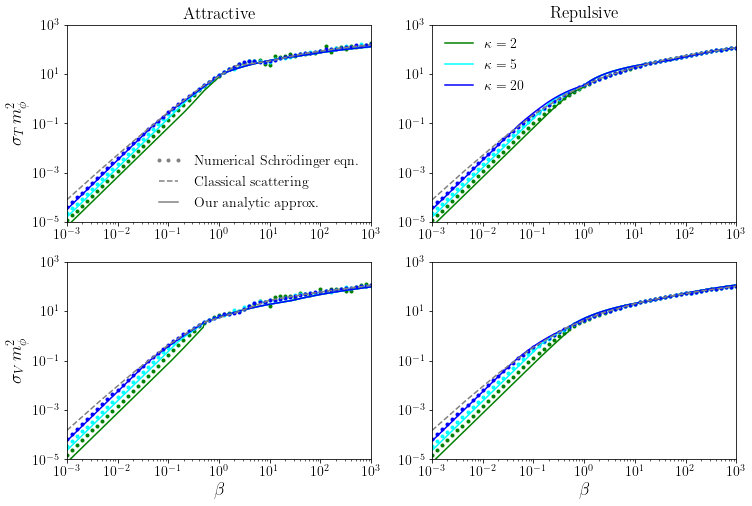

In [247]:
# plot vs beta

fig, axs = plt.subplots(2, 2, figsize=(12,12/1.5))

beta_strings = ['kappa_2', 'kappa_5', 'kappa_20']
color_list = ['green', 'cyan', 'blue']

lx = [1,10]
ly = [1e-20,1e-20]
axs[0,0].plot(lx,ly,'.',color='gray')
axs[0,0].plot(lx,ly,color='gray',linestyle='dashed')
axs[0,0].plot(lx,ly,color='gray',linestyle='solid')
axs[0,0].legend([r'Numerical Schr\"odinger eqn.', 'Classical scattering', 'Our analytic approx.'],frameon=False,numpoints=3)

axs[0,1].plot(lx,ly,color=color_list[0])
axs[0,1].plot(lx,ly,color=color_list[1])
axs[0,1].plot(lx,ly,color=color_list[2])
axs[0,1].legend([r'$\kappa=2$', r'$\kappa=5$', r'$\kappa=20$'],frameon=False)


for bs,c in zip(beta_strings, color_list):

    # Numerical plot: attractive
    num_data = get_numerical_data(bs, 'attractive_beta')
    kappa = num_data[0,1]
    beta = num_data[:,0]
    sig_T = num_data[:,2]
    sig_V = num_data[:,3]
    axs[0,0].plot(beta,sig_T,'.',color=c)
    axs[1,0].plot(beta,sig_V,'.',color=c)

    # Numerical plot: repulsive
    num_data = get_numerical_data(bs, 'repulsive_beta')
    kappa = num_data[0,1]
    beta = num_data[:,0]
    sig_T = num_data[:,2]
    sig_V = num_data[:,3]
    axs[0,1].plot(beta,sig_T,'.',color=c)
    axs[1,1].plot(beta,sig_V,'.',color=c)

kappa_list = [2,5,20]
for kappa, c in zip(kappa_list, color_list):
    
    beta = np.logspace(-3,3,num=300)
    
    sig = [ np.pi*sigma(kappa, b, mode = 'T', sign = 'attractive') for b in beta ]
    axs[0,0].plot(beta, sig, color=c)
    
    sig = [ np.pi*sigma(kappa, b, mode = 'T', sign = 'repulsive') for b in beta ]
    axs[0,1].plot(beta, sig, color=c)
    
    sig = [ np.pi*sigma(kappa, b, mode = 'V', sign = 'attractive') for b in beta ]
    axs[1,0].plot(beta, sig, color=c)
    
    sig = [ np.pi*sigma(kappa, b, mode = 'V', sign = 'repulsive') for b in beta ]
    axs[1,1].plot(beta, sig, color=c)

# classical result
beta = np.logspace(-3,3,num=10)

sig = [ sigma_T_classical(-b,kappa=1000) for b in beta ]
axs[0,0].plot(beta, sig, color = 'gray', linestyle='--')

sig = [ sigma_T_classical(b,kappa=1000) for b in beta ]
axs[0,1].plot(beta, sig, color = 'gray', linestyle='--')

sig = [ sigma_V_classical(-b,kappa=1000) for b in beta ]
axs[1,0].plot(beta, sig, color = 'gray', linestyle='--')

sig = [ sigma_V_classical(b,kappa=1000) for b in beta ]
axs[1,1].plot(beta, sig, color = 'gray', linestyle='--')
    
axs[0, 0].set_title('Attractive')
axs[0, 1].set_title('Repulsive')

for ax in axs:
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlim([1e-3,1e3])
        a.set_ylim([1e-5,1e3])
        
axs[1,0].set_xlabel(r'$\beta$', fontsize=18)
axs[1,1].set_xlabel(r'$\beta$', fontsize=18)

axs[0,0].set_ylabel(r'$\sigma_T \, m_\phi^2$', fontsize=18)
axs[1,0].set_ylabel(r'$\sigma_V \, m_\phi^2$', fontsize=18)

plt.savefig('beta_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()